In [ ]:
display(HTML(r"""
<div class="dataset-box">
  <div class="dataset-title">
    Dataset Overview — Pb–Pb at √s<sub>NN</sub> = 5.02 TeV
  </div>

  <div class="dataset-grid">
    <div class="dataset-card">
      <div class="dataset-card-title">Experiment</div>
      <div class="dataset-row">
        <div class="dataset-key">Accelerator</div><div>LHC (CERN)</div>
        <div class="dataset-key">Experiment</div><div>ALICE</div>
        <div class="dataset-key">System</div><div>Pb–Pb</div>
        <div class="dataset-key">Energy</div><div>√s<sub>NN</sub> = 5.02 TeV</div>
        <div class="dataset-key">Final state</div><div>Charged particles</div>
      </div>
    </div>

    <div class="dataset-card">
      <div class="dataset-card-title">Observable & Selection</div>
      <div class="dataset-row">
        <div class="dataset-key">Observable</div><div>v<sub>0</sub>(p<sub>T</sub>)</div>
        <div class="dataset-key">p<sub>T</sub> range</div><div>0.55 – 9.46 GeV</div>
        <div class="dataset-key">Centrality</div><div>50–60%</div>
        <div class="dataset-key">Data</div>
        <div>
          <a class="dataset-link" href="https://www.hepdata.net/record/160790" target="_blank">
            HEPData DOI
          </a>
        </div>
      </div>
    </div>
  </div>

  <div class="dataset-footer">
    <div><b>CSV:</b> HEPData-ins2907010-v1-Figure_4a_cent7.csv</div>
    <div><b>Source:</b> HEPData (Table DOI)</div>
  </div>
</div>
"""))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def read_hepdata_csv(path):
    # pula linhas de comentário iniciadas com '#'
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            # separa por vírgula
            parts = [p.strip() for p in line.split(",")]
            rows.append(parts)

    data = np.array(rows, dtype=float)

    pT   = data[:, 0]
    y    = data[:, 1]
    stat_p, stat_m = data[:, 2], data[:, 3]
    syst_p, syst_m = data[:, 4], data[:, 5]

    # transforma em 1 sigma simétrico (média dos módulos)
    sig_stat = 0.5 * (np.abs(stat_p) + np.abs(stat_m))
    sig_syst = 0.5 * (np.abs(syst_p) + np.abs(syst_m))

    return pT, y, sig_stat, sig_syst
    

In [ ]:
def se_kernel(x, xp, sigma_f, ell):
    """Squared Exponential kernel"""
    x = x.reshape(-1, 1)
    xp = xp.reshape(-1, 1)
    d2 = (x - xp.T) ** 2
    return (sigma_f**2) * np.exp(-0.5 * d2 / (ell**2))



In [13]:
def gp_posterior(x_train, y_train, x_test, K_func, Sigma_noise):
    """
    y ~ N(0, K_func(x,x) + Sigma_noise)
    posterior over f(x_test)
    """
    Kxx = K_func(x_train, x_train)
    Kxs = K_func(x_train, x_test)
    Kss = K_func(x_test,  x_test)

    C = Kxx + Sigma_noise

    # Cholesky para estabilidade numérica
    L = np.linalg.cholesky(C + 1e-12*np.eye(C.shape[0]))

    # alpha = C^{-1} y via cho_solve manual
    # resolve L v = y
    v = np.linalg.solve(L, y_train)
    # resolve L^T alpha = v
    alpha = np.linalg.solve(L.T, v)

    # mean = Kxs^T alpha
    mu = Kxs.T @ alpha

    # cov = Kss - Kxs^T C^{-1} Kxs
    # resolve L w = Kxs
    w = np.linalg.solve(L, Kxs)
    cov = Kss - w.T @ w

    return mu, cov

In [14]:
def log_marginal_likelihood(y, K_func, Sigma_noise, x_train):
    Kxx = K_func(x_train, x_train)
    C = Kxx + Sigma_noise
    L = np.linalg.cholesky(C + 1e-12*np.eye(C.shape[0]))

    # log|C| = 2 sum log diag(L)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))

    # y^T C^{-1} y
    v = np.linalg.solve(L, y)
    quad = v.T @ v

    n = y.shape[0]
    return -0.5*quad - 0.5*logdet - 0.5*n*np.log(2*np.pi)

In [15]:
csv_path = "HEPData-ins2907010-v1-Figure_4a_cent7.csv"  # <-- ajuste aqui
pT, y, sig_stat, sig_syst = read_hepdata_csv(csv_path)

# ordena por pT (só por segurança)
idx = np.argsort(pT)
pT, y, sig_stat, sig_syst = pT[idx], y[idx], sig_stat[idx], sig_syst[idx]

# grid de teste pra desenhar curva suave
pT_star = np.linspace(pT.min(), pT.max(), 300)

# Função kernel do "sinal físico"
def make_Kfunc(sigma_f, ell):
    return lambda a, b: se_kernel(a, b, sigma_f=sigma_f, ell=ell)

# --- Modelo A: ruído DIAGONAL (stat+syst em quadratura)
def Sigma_diag():
    return np.diag(sig_stat**2 + sig_syst**2)

# --- Modelo B: ruído CORRELACIONADO no sistemático (SE no pT)
# Sigma = diag(sig_stat^2) + alpha^2 * (sig_syst_i sig_syst_j) * exp(- (ΔpT)^2 / (2 ell_s^2))
def Sigma_corr(alpha, ell_s):
    base = np.diag(sig_stat**2)
    # matriz de correlação SE
    d2 = (pT.reshape(-1,1) - pT.reshape(1,-1))**2
    R = np.exp(-0.5 * d2 / (ell_s**2))
    Ksys = (sig_syst.reshape(-1,1) * sig_syst.reshape(1,-1)) * R
    return base + (alpha**2) * Ksys


In [16]:
sigma_f_grid = np.linspace(0.01, 0.5, 25)
ell_grid     = np.linspace(0.1, 5.0, 30)

# Modelo A
best_A = (-np.inf, None)
for sigma_f in sigma_f_grid:
    for ell in ell_grid:
        Kf = make_Kfunc(sigma_f, ell)
        lml = log_marginal_likelihood(y, Kf, Sigma_diag(), pT)
        if lml > best_A[0]:
            best_A = (lml, (sigma_f, ell))

# Modelo B (inclui alpha e ell_s)
alpha_grid = np.linspace(0.1, 2.0, 20)
ell_s_grid = np.linspace(0.3, 10.0, 25)

best_B = (-np.inf, None)
for sigma_f in sigma_f_grid:
    for ell in ell_grid:
        Kf = make_Kfunc(sigma_f, ell)
        for alpha in alpha_grid:
            for ell_s in ell_s_grid:
                Sig = Sigma_corr(alpha, ell_s)
                lml = log_marginal_likelihood(y, Kf, Sig, pT)
                if lml > best_B[0]:
                    best_B = (lml, (sigma_f, ell, alpha, ell_s))

print("Best A (diag):    LML=%.2f  sigma_f=%.4f  ell=%.4f" % (best_A[0], *best_A[1]))
print("Best B (corr):    LML=%.2f  sigma_f=%.4f  ell=%.4f  alpha=%.4f  ell_s=%.4f" % (best_B[0], *best_B[1]))



Best A (diag):    LML=115.59  sigma_f=0.1733  ell=3.3103
Best B (corr):    LML=125.35  sigma_f=0.1529  ell=2.8034  alpha=0.5000  ell_s=0.3000


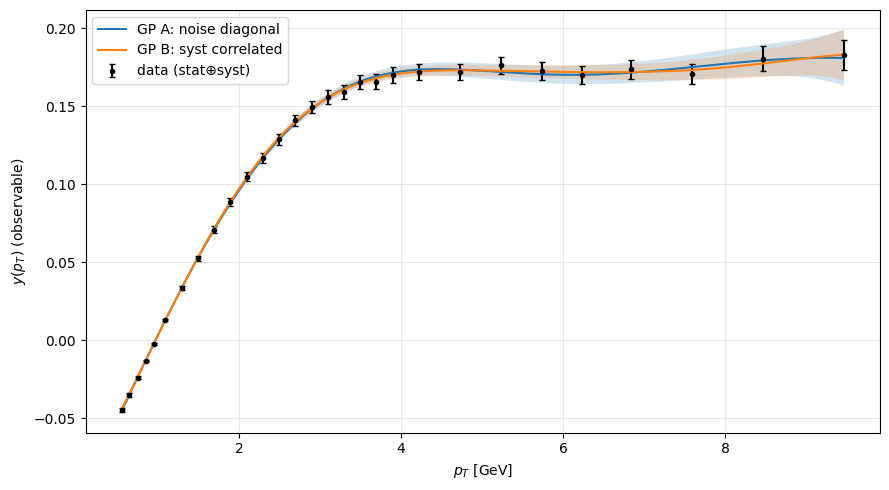

In [17]:
# Modelo A
sigma_fA, ellA = best_A[1]
KfA = make_Kfunc(sigma_fA, ellA)
muA, covA = gp_posterior(pT, y, pT_star, KfA, Sigma_diag())
stdA = np.sqrt(np.clip(np.diag(covA), 0, np.inf))

# Modelo B
sigma_fB, ellB, alphaB, ell_sB = best_B[1]
KfB = make_Kfunc(sigma_fB, ellB)
SigB = Sigma_corr(alphaB, ell_sB)
muB, covB = gp_posterior(pT, y, pT_star, KfB, SigB)
stdB = np.sqrt(np.clip(np.diag(covB), 0, np.inf))

# Plot
plt.figure(figsize=(9,5))

# Dados com barras (usei total como visualização; modelo B separa stat/syst internamente)
yerr_tot = np.sqrt(sig_stat**2 + sig_syst**2)
plt.errorbar(pT, y, yerr=yerr_tot, fmt="k.", capsize=2, label="data (stat⊕syst)")

# GP A
plt.plot(pT_star, muA, label="GP A: noise diagonal")
plt.fill_between(pT_star, muA-2*stdA, muA+2*stdA, alpha=0.2)

# GP B
plt.plot(pT_star, muB, label="GP B: syst correlated")
plt.fill_between(pT_star, muB-2*stdB, muB+2*stdB, alpha=0.2)

plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel(r"$y(p_T)$ (observable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
from IPython.display import HTML, display

display(HTML(r"""
<style>

/* ====== Dataset (tema escuro) — versão COMPACTA ====== */
.dataset-box{
  background: linear-gradient(135deg, #0f2027, #203a43, #2c5364);
  color:#f5f7fa;

  /* ↓ era 22px 26px */
  padding: 14px 16px;

  margin: 0;
  border-radius: 14px;
  box-shadow: 0 10px 30px rgba(0,0,0,0.30);
  font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif;

  display:block;
  width:100%;
  max-width:none;
  box-sizing:border-box;
}

/* ↓ título menor + menos espaço */
.dataset-title{
  font-size: 1.9em;     /* era 1.9em */
  font-weight: 700;
  margin: 0 0 8px 0;     /* era 0 0 12px 0 */
  line-height: 1.2;
}

/* ↓ duas colunas mais próximas */
.dataset-grid{
  display:grid;
  grid-template-columns: 1fr 1fr;
  gap: 18px;             /* era 28px */
}

/* ↓ cards internos mais “finos” */
.dataset-card{
  background: rgba(255,255,255,0.06);
  border-radius: 12px;
  padding: 10px 12px;    /* era 14px 16px */
}

/* ↓ cabeçalho do card mais compacto */
.dataset-card-title{
  font-weight: 800;
  margin: 0 0 8px 0;     /* era 10px */
  font-size: 1.0em;
}

/* ↓ linhas “coladas” e tipografia mais curta */
.dataset-row{
  display:grid;
  grid-template-columns: 120px 1fr; /* era 140px 1fr */
  row-gap: 2px;                     /* era 6px */
  column-gap: 10px;
  line-height: 1.15;
  font-size: 0.95em;                /* compacta sem sumir */
}

.dataset-key{ color:#cfe7f5; }

/* ↓ rodapé bem discreto */
.dataset-footer{
  margin-top: 12px;      /* era 14px */
  font-size: 0.95em;     /* era 0.95em */
  color: #cfe7f5;
  display:flex;
  justify-content:space-between;
  flex-wrap:wrap;
  gap:8px;               /* era 10px */
}

/* ====== Patch Jupyter (mantém span total) ====== */
div.output_html.rendered_html.output_subarea{
  width:100% !important;
  max-width:100% !important;
  flex:0 0 100% !important;
  box-sizing:border-box !important;
}
div.output_html.rendered_html{
  padding-left:0 !important;
  padding-right:0 !important;
}

</style>
"""))